In [3]:
import pandas as pd
import numpy as np
from dataset import TissueSegmentationDataset
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm
from PIL import Image
from model import HalfDualDecUNetPP
import torch.nn as nn
import os
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches

#### EVAL

In [2]:
# Load model
from model import HalfDualDecUNetPP

weight_path = r"C:\Users\akoukash\Work_lab\AID\training\logs\AID3\best_f1.pt"

model = HalfDualDec()
model.load_state_dict(torch.load(weight_path))
model = nn.Sequential(model, nn.Sigmoid())
model = model.cuda()
model.eval()


# model_soft = HalfDualDec()
# model_soft.load_state_dict(torch.load(weight_path))
# model_soft = nn.Sequential(model_soft, nn.Softmax(dim=1))
# model_soft = model_soft.cuda()
# model_soft.eval()

Sequential(
  (0): HalfDualDec(
    (encoder): DenseNetEncoder(
      (features): Sequential(
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu0): ReLU(inplace=True)
        (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (denseblock1): _DenseBlock(
          (denselayer1): _DenseLayer(
            (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLay

In [3]:
def mask_to_color_image(mask):
    class_map = {
        0: (0, 0, 0),
        1: (255, 0, 0),
        2: (251, 220, 0),
        3: (255, 128, 0),
        4: (0, 0, 255),
        5: (255, 0, 255),
        6: (0, 255, 0),
        7: (0, 255, 255),
        8: (128, 128, 128),
    }

    mask_np = np.array(mask)
    color_mask = np.zeros(
        (mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
    for value, color in class_map.items():
        color_mask[mask_np == value] = color
    return Image.fromarray(color_mask)


list_classes = [
    "Background",
    "Adénocarcinome",
    "Adénomateux BG",
    "Adénomateux HG",
    "Autr",
    "Lésion sessile festonnée",
    "Muqueuse normale",
    "Polype hyperplasique",
    "Tissue Background",
]

class_map = {
    "Background": (0, 0, 0),
    "Adénocarcinome": (255, 0, 0),
    "Adénomateux BG": (255, 255, 0),
    "Adénomateux HG": (230, 108, 0),
    "Autr": (0, 0, 255),
    "Lésion sessile festonnée": (255, 0, 255),
    "Muqueuse normale": (0, 255, 0),
    "Polype hyperplasique": (0, 255, 255),
    "Tissue Background": (128, 128, 128),
}


def apply_mapping_to_mask_grayscale(mask):
    mapping = {
        0: 0,  # Background OK
        18: 6,  # Muqueuse normale OK
        36: 6,  # Muqueuse normale OK
        54: 7,  # Polype hyperplasique
        72: 7,  # Polype hyperplasique
        91: 5,  # Lésion sessile festonnée
        109: 5,  # Lésion sessile festonnée
        127: 2,  # Adénomateux BG
        145: 2,  # Adénomateux BG
        163: 3,  # Adénomateux HG
        182: 3,  # Adénomateux HG
        200: 1,  # Adénocarcinome
        218: 1,  # Adénocarcinome
        236: 4,  # Autre
        255: 4,  # Autre
        10: 8,  # Tissue without class
    }

    mask[:] = np.vectorize(mapping.get)(mask)

    return mask

In [4]:
l = []
def make_pred(slide_name, mask_path, wsi_path):

    slide = openslide_web_wrapper.open_slide(wsi_path, magnification_lvl0=10)
    roi_slide = slide.roi_slide(
        roi=[0, 0] + list(slide.dimensions), magnification=10)
    patch_arr = np.array(
        roi_slide.read_region((0, 0), 0, roi_slide.dimensions).convert("RGB")
    )
    foreground = None
    from scipy.ndimage import gaussian_filter

    ps = 256
    wf = patch_operations.window_function_hahn(ps, ps)

    probs = patch_operations.wsi2probs(
        slide=patch_arr,
        patch_size=ps,
        patch_overlap=32,
        include_border_patches=True,
        batch_size=16,
        model=model,
        mask=foreground,
        mask_patch_inclusion_threshold=0.1,
    )
    probsim = patch_operations.probs2wsi(
        slide_dim=patch_arr.shape[:2],
        patch_size=ps,
        generator_locs_probs=probs,
        window_function=wf,
    )
    print(probsim.shape)

    mask = np.argmax(probsim, axis=2)
    mask = mask_to_color_image(mask)

    class_5_probs = probsim[:, :, 5]


    l.append(class_5_probs.flatten())

    #n_classes = probsim.shape[2]
    #smoothed_probsim = np.zeros_like(probsim)
    #for i in range(n_classes):
    #    smoothed_probsim[:, :, i] = gaussian_filter(probsim[:, :, i], sigma=50)
    #mask_gaus = np.argmax(smoothed_probsim, axis=2)
    #colored_predicted_mask = mask_to_color_image(mask_gaus)

    true_mask = np.array(Image.open(mask_path))
    true_mask = apply_mapping_to_mask_grayscale(true_mask)
    true_mask = mask_to_color_image(true_mask)

    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(patch_arr)
    axs[0].set_title("Original")
    axs[0].axis("off")

    axs[1].imshow(true_mask)
    axs[1].set_title("True Mask")
    axs[1].axis("off")

    axs[2].imshow(mask)
    axs[2].set_title("Predicted Mask")
    axs[2].axis("off")

    # axs[3].imshow(colored_predicted_mask)
    # axs[3].set_title("Predicted Mask gaussian")
    # axs[3].axis("off")

    patches = [
        mpatches.Patch(color=np.array(color) / 255.0, label=class_name)
        for class_name, color in class_map.items()
    ]
    plt.legend(handles=patches, bbox_to_anchor=(
        1.05, 1), loc=2, borderaxespad=0.0)
    fig.suptitle(slide_name)

    save_path = os.path.join(SAVE_FOLDER, f"{slide_name}.png")
    plt.savefig(save_path, bbox_inches="tight")
    plt.close(fig)

In [5]:
SAVE_FOLDER = r"C:\Users\akoukash\Work_lab\AID\training\logs\AID3\preds"
df = pd.read_csv(r"C:\Users\akoukash\Work_lab\AID\training\dataset\eval_Batch_1.csv")


names = df["slide"].tolist()
slides_path = df["wsi_path"].tolist()
masks_path = df["mask_path"].tolist()
v = 20

for name, slide, mask in zip(names, slides_path, masks_path):
    make_pred(name, mask, slide)
    if v ==0:
        break
    else:
        v-=1

c:\users\akoukash\work_lab\tribun_patchio\tribun_patchio\openslide_web_wrapper.py:127: UserWarning: local image has no resolution metadata. You can set it by providing the 'resolution_lvl0' argument.
  warnings.warn(
c:\users\akoukash\work_lab\tribun_patchio\tribun_patchio\datasets.py:275: UserWarning: ImageSlide, Openslide or numpy array objects are not compatible with asynchronous loading.
  warnings.warn("ImageSlide, Openslide or numpy array objects are not"
100%|██████████| 43/43 [00:12<00:00,  3.35it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.08it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.11it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.15it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.12it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.15it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.19it/s]


(5659, 5660, 9)


100%|██████████| 43/43 [00:10<00:00,  4.21it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.16it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.18it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.21it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.19it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.14it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.15it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.16it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.17it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.17it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.20it/s]


(5660, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.18it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.16it/s]


(5659, 5659, 9)


100%|██████████| 43/43 [00:10<00:00,  4.20it/s]


(5659, 5659, 9)


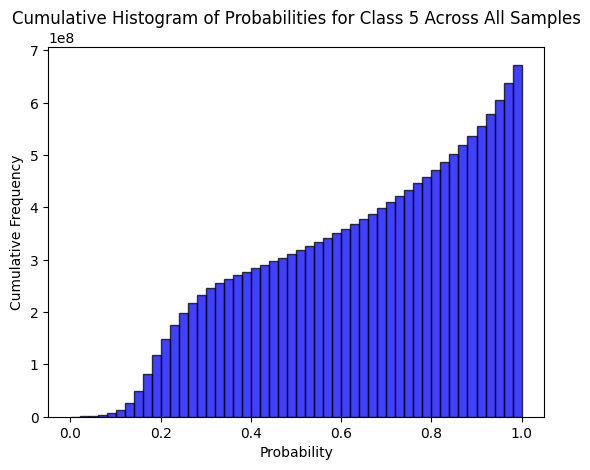

In [10]:
all_probs = np.concatenate(l)

plt.hist(all_probs, bins=50, alpha=0.75, color='blue', edgecolor='black', cumulative=True)
plt.title('Cumulative Histogram of Probabilities for Class 5 Across All Samples')
plt.xlabel('Probability')
plt.ylabel('Cumulative Frequency')
plt.show()